In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import matplotlib.patches as mpatches

from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from scipy.stats import spearmanr

import scienceplots  # noqa

import patato as pat

from paiskintonetools import setup_matplotlib, get_example_scan_of_type
from paiskintonetools.stats import loess_bootstrap

from pathlib import Path

plt.style.use("high-contrast")
plt.rcParams["svg.fonttype"] = "none"
colours = ["C0", "C1", "C2"]

setup_matplotlib(dpi=300)

In [2]:
itas = (
    pd.read_parquet("../01_Prepare Data/pa_values_extracted_all_meta.parquet")
    .set_index(["SkinID", "Region"])
    .loc[(slice(None, None), "Leg"),]
    .groupby(level=[0, 1])
    .first()
)
itas = itas.query("`Fitzpatrick Type`!='Vitiligo'")
# display(itas.head())
itas = itas.sort_values("ITA").reset_index()
index_to_use = np.linspace(0, itas.shape[0] - 1, 3).astype(int)[::-1]
index_to_use[-1] += 1

examples = itas[["SkinID", "ITA"]].iloc[index_to_use].reset_index(drop=True)

In [3]:
root_data_path = Path("../Data")

0.03068002122049488
0.001013744270068208
0.557846720395504


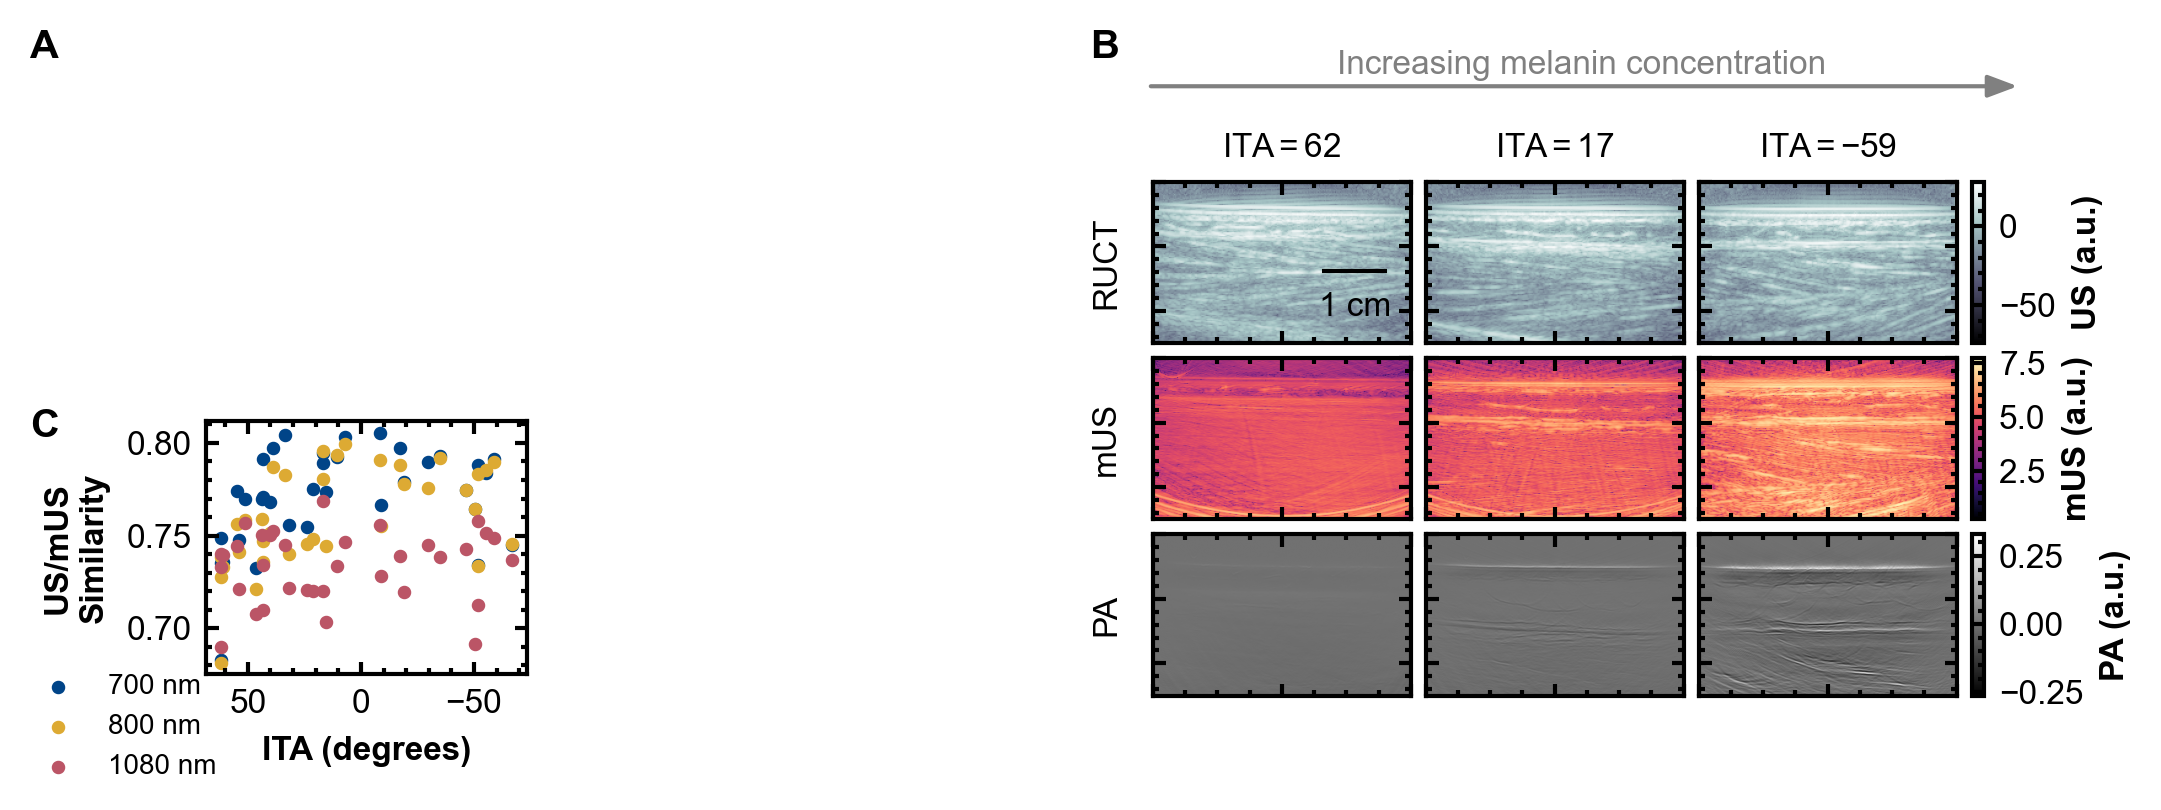

In [4]:
fig = plt.figure(constrained_layout=True, figsize=(7, 5 / 2))

subfiga, subfigb = fig.subfigures(1, 2)

_, subfig_int = subfiga.subfigures(2)
subfigd, _ = subfig_int.subfigures(1, 2)

subfiga.text(0, 1, "A", va="top", ha="left", fontsize="large", fontweight="bold")
subfigb.text(0, 1, "B", va="top", ha="left", fontsize="large", fontweight="bold")

subfigd.text(0, 1, "C", va="top", ha="left", fontsize="large", fontweight="bold")

# subfigb is the image grid basically:
axes_images = ImageGrid(
    subfigb,
    (0.06, 0.005, 0.8, 0.9),  # similar to subplot(111)
    nrows_ncols=(3, 3),
    axes_pad=0.05,  # pad between Axes in inch.
    share_all=True,
    label_mode="all",
    cbar_mode="edge",
)

axes_images[0].set_ylim([-0.015, 0.01])
axes_images[0].set_xlim([-0.02, 0.02])
for ax in axes_images:
    ax.yaxis.set_tick_params(labelleft=False)
    ax.xaxis.set_tick_params(labelbottom=False)


asb = AnchoredSizeBar(
    axes_images[-1].transData,
    0.01,
    "1 cm",
    loc="lower right",
    pad=0.1,
    borderpad=0.5,
    sep=5,
    frameon=False,
    color="k",
)
axes_images[0].add_artist(asb)

arr = mpatches.FancyArrowPatch(
    (0.05, 0.925),
    (0.9, 0.925),
    arrowstyle="-|>,head_width=.15",
    mutation_scale=15,
    transform=subfigb.transSubfigure,
    clip_on=False,
    color="gray",
)
axes_images[0].add_patch(arr)
axes_images[0].annotate(
    "Increasing melanin concentration",
    (0.5, 0.8),
    xycoords=arr,
    ha="center",
    va="bottom",
    color="gray",
)

ims = []
for i, example in examples.iterrows():
    ita = example["ITA"]
    title = r"$\mathdefault{ITA = " + f"{ita:.0f}" + "}$"
    axes_images[i].set_title(title, fontweight="normal", fontsize="medium")

    skin_id_to_show = example["SkinID"]

    example_scan = get_example_scan_of_type(root_data_path / skin_id_to_show, "leg")
    pa = pat.PAData.from_hdf5(example_scan)
    rec = pa.get_scan_reconstructions()["Model Based", "0"]
    xs = rec.da.coords["x"].values
    pa_weighting = np.exp(xs / 0.0075)
    im_pa = axes_images[6 + i].imshow(
        rec.raw_data[0, 0, 50:300, 0] / pa_weighting[50:300, None],
        origin="lower",
        extent=(-0.02, 0.02, -0.015, 0.01),
        cmap="gray",
    )

    us = pa.get_ultrasound()
    im_us = axes_images[i].imshow(
        us.raw_data[0, 0, :, 0], origin="lower", extent=us.extent, cmap="bone"
    )

    maUS = np.load(Path("Output") / skin_id_to_show / (example_scan.stem + ".npy"))[
        :, 40:-40, 40:-40
    ]
    im_maus = axes_images[3 + i].imshow(
        np.flipud(maUS[0]), origin="lower", cmap="magma", extent=rec.extent
    )
    ims.append(im_us)
    ims.append(im_maus)
    ims.append(im_pa)

labels = ["US (a.u.)", "mUS (a.u.)", "PA (a.u.)"]
for i in range(len(labels)):
    # Set the clims for wavelengths
    clims = [[], []]
    for im in ims[i::3]:
        clims[0].append(im.get_clim()[0])
        clims[1].append(im.get_clim()[1])
    for im in ims[i::3]:
        im.set_clim((np.min(clims[0]), np.max(clims[1])))
    # if unmixed_to_plot[i] == "sO2":
    #     axes_images
    axes_images.cbar_axes[i].colorbar(ims[i], label=labels[i])

for ax, label in zip(axes_images[::3], ["RUCT", "mUS", "PA"]):
    ax.set_ylabel(label, fontweight="normal", fontsize="medium")

ax = subfigd.subplots()

df_summary = pd.read_parquet("pw_us_sim_labelled.parquet")
df_summary = df_summary[df_summary["Label"] == "Leg"]
for n, g in df_summary.groupby("Wavelengths"):
    if n not in [700, 800, 1080]:
        continue
    ax.scatter(g["ITA"], g["FSIM"], s=5, label=f"{n:.0f} nm")
    print(spearmanr(g["ITA"], g["FSIM"]).pvalue)
ax.invert_xaxis()
subfigd.legend(
    *ax.get_legend_handles_labels(),
    loc="lower left",
    fontsize="small",
    borderpad=0,
    fancybox=False,
    borderaxespad=0,
)
ax.set_xlabel("ITA (degrees)")
ax.set_ylabel("US/mUS\nSimilarity")
plt.savefig("figure7.pdf", dpi=300)
plt.savefig("figure7.svg", dpi=300)
plt.show()

In [5]:
pd.unique(
    pd.read_parquet("../01_Prepare Data//pa_values_extracted_all_meta.parquet")[
        "Region"
    ]
)

array(['Bicep', 'Carotid Artery', 'Leg', 'Radial Artery', 'Ulnar Artery',
       'Brachial Artery'], dtype=object)

,SkinID,ITA
0,SKIN01,70.370
1,SKIN18,20.590
2,SKIN19,-31.844


..\Data\SKIN01
..\Data\SKIN01\Scan_10.hdf5
..\Data\SKIN18
..\Data\SKIN18\Scan_8.hdf5
..\Data\SKIN19
..\Data\SKIN19\Scan_8.hdf5


C:\Users\tomelse\AppData\Local\Temp\ipykernel_11888\4049779849.py:130: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(f"figure7_sup_{region.lower()}.pdf", dpi=300)
C:\Users\tomelse\AppData\Local\Temp\ipykernel_11888\4049779849.py:131: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(f"figure7_sup_{region.lower()}.svg", dpi=300)
c:\Users\tomelse\Local\CambridgeBits\PAISKINTONE\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


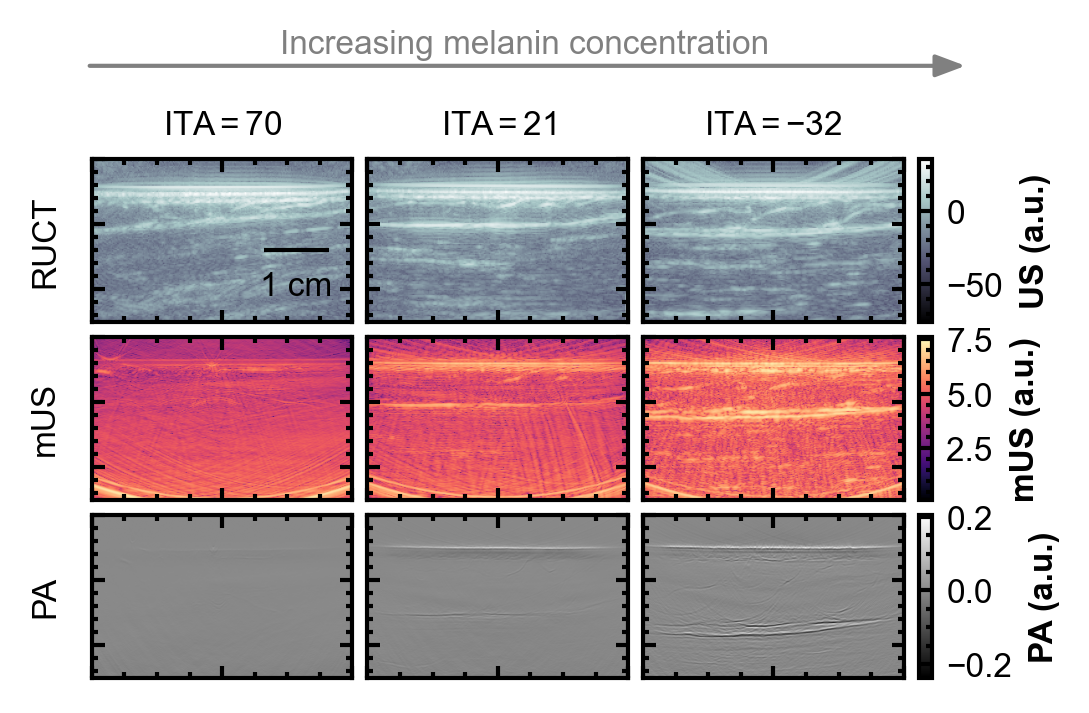

,SkinID,ITA
0,SKIN01,64.518
1,SKIN25,17.050
2,SKIN38,-42.130


..\Data\SKIN01
..\Data\SKIN01\Scan_7.hdf5
..\Data\SKIN25
..\Data\SKIN25\Scan_5.hdf5
..\Data\SKIN38
..\Data\SKIN38\Scan_5.hdf5


C:\Users\tomelse\AppData\Local\Temp\ipykernel_11888\4049779849.py:130: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(f"figure7_sup_{region.lower()}.pdf", dpi=300)
C:\Users\tomelse\AppData\Local\Temp\ipykernel_11888\4049779849.py:131: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(f"figure7_sup_{region.lower()}.svg", dpi=300)
c:\Users\tomelse\Local\CambridgeBits\PAISKINTONE\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


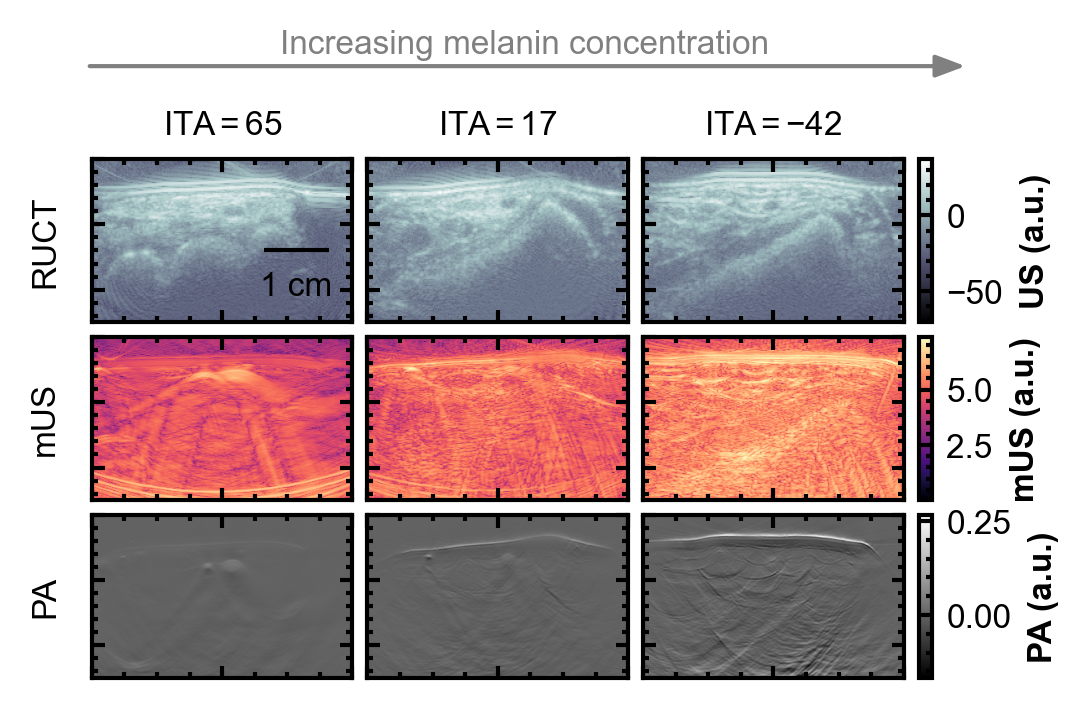

,SkinID,ITA
0,SKIN01,54.196000
1,SKIN03,17.108000
2,SKIN38,-67.306667


..\Data\SKIN01
..\Data\SKIN01\Scan_13.hdf5
..\Data\SKIN03
..\Data\SKIN03\Scan_11.hdf5
..\Data\SKIN38
..\Data\SKIN38\Scan_11.hdf5


C:\Users\tomelse\AppData\Local\Temp\ipykernel_11888\4049779849.py:130: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(f"figure7_sup_{region.lower()}.pdf", dpi=300)
C:\Users\tomelse\AppData\Local\Temp\ipykernel_11888\4049779849.py:131: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(f"figure7_sup_{region.lower()}.svg", dpi=300)
c:\Users\tomelse\Local\CambridgeBits\PAISKINTONE\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


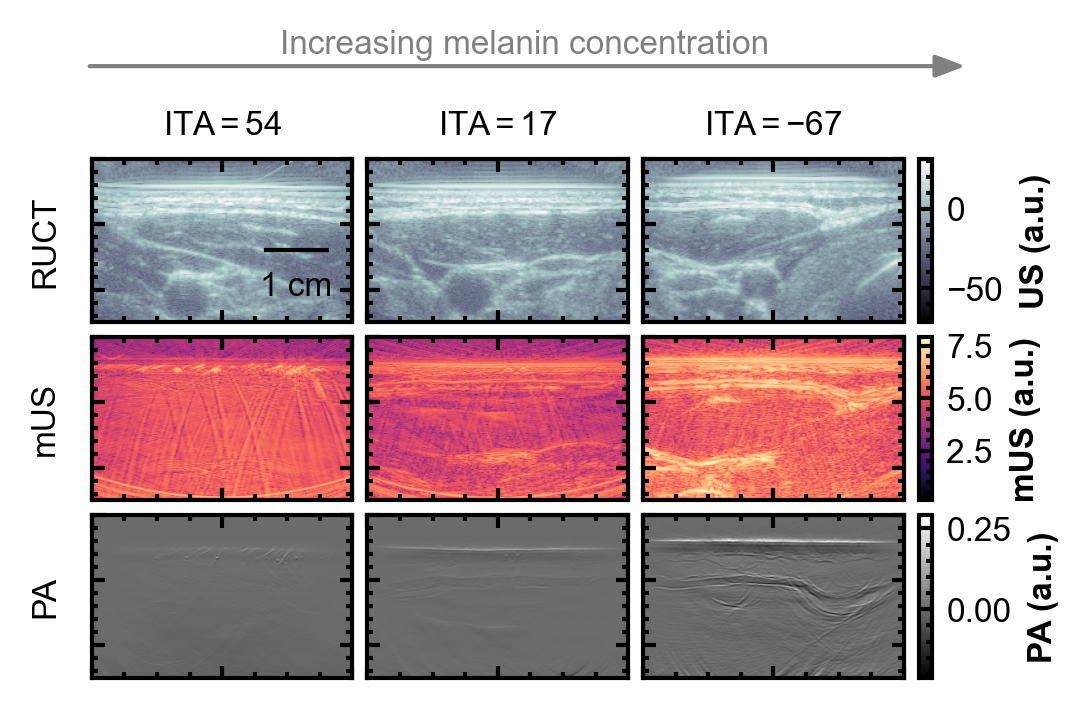

,SkinID,ITA
0,SKIN20,62.102
1,SKIN17,16.844
2,SKIN31,-58.674


..\Data\SKIN20
..\Data\SKIN20\Scan_2.hdf5
..\Data\SKIN17
..\Data\SKIN17\Scan_2.hdf5
..\Data\SKIN31
..\Data\SKIN31\Scan_2.hdf5


C:\Users\tomelse\AppData\Local\Temp\ipykernel_11888\4049779849.py:130: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(f"figure7_sup_{region.lower()}.pdf", dpi=300)
C:\Users\tomelse\AppData\Local\Temp\ipykernel_11888\4049779849.py:131: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(f"figure7_sup_{region.lower()}.svg", dpi=300)
c:\Users\tomelse\Local\CambridgeBits\PAISKINTONE\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


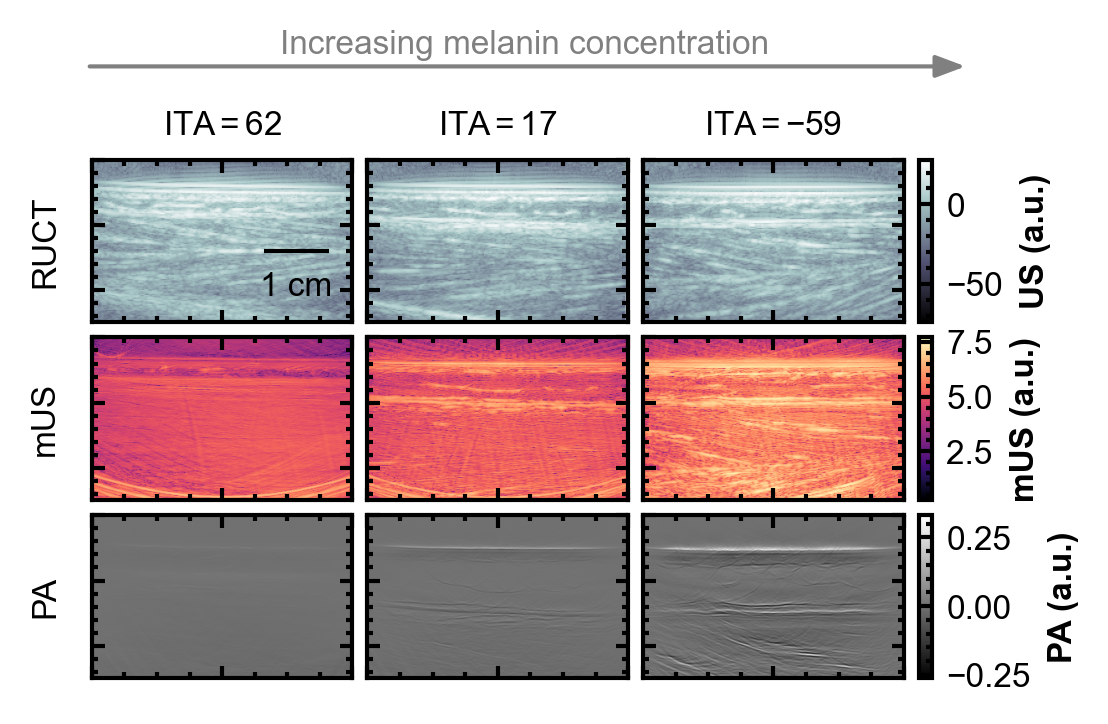

In [6]:
# Make imge grids for all the other imaging positions:
for region in ["Bicep", "Forearm", "Neck", "Leg"]:
    regions = {"Forearm": "Radial Artery", "Neck": "Carotid Artery"}
    region_filter = regions.get(region, region)
    itas = (
        pd.read_parquet("../01_Prepare Data//pa_values_extracted_all_meta.parquet")
        .set_index(["SkinID", "Region"])
        .loc[(slice(None, None), region_filter),]
        .groupby(level=[0, 1])
        .first()
    )
    itas = itas.query("`Fitzpatrick Type`!='Vitiligo'")
    # itas = pd.read_parquet("../SummaryTables/ita_etc.parquet").loc[
    #     (slice(None, None), region),
    # ]
    itas = itas.sort_values("ITA").reset_index()
    index_to_use = np.linspace(0, itas.shape[0] - 1, 3).astype(int)[::-1]
    if region == "Bicep":
        index_to_use[-1] += 2
    if region == "Leg":
        index_to_use[-1] += 1
    # index_to_use[-1] +=1
    examples = itas[["SkinID", "ITA"]].iloc[index_to_use].reset_index(drop=True)
    display(examples)
    subfigb = plt.figure(figsize=(3.5, 5 / 2), constrained_layout=False)

    # subfigb is the image grid basically:
    axes_images = ImageGrid(
        subfigb,
        (0.06, 0.005, 0.8, 0.9),  # similar to subplot(111)
        nrows_ncols=(3, 3),
        axes_pad=0.05,  # pad between Axes in inch.
        share_all=True,
        label_mode="all",
        cbar_mode="edge",
    )

    axes_images[0].set_ylim([-0.015, 0.01])
    axes_images[0].set_xlim([-0.02, 0.02])
    for ax in axes_images:
        ax.yaxis.set_tick_params(labelleft=False)
        ax.xaxis.set_tick_params(labelbottom=False)

    asb = AnchoredSizeBar(
        axes_images[-1].transData,
        0.01,
        "1 cm",
        loc="lower right",
        pad=0.1,
        borderpad=0.5,
        sep=5,
        frameon=False,
        color="k",
    )
    axes_images[0].add_artist(asb)

    arr = mpatches.FancyArrowPatch(
        (0.05, 0.925),
        (0.9, 0.925),
        arrowstyle="-|>,head_width=.15",
        mutation_scale=15,
        transform=subfigb.transSubfigure,
        clip_on=False,
        color="gray",
    )
    axes_images[0].add_patch(arr)
    axes_images[0].annotate(
        "Increasing melanin concentration",
        (0.5, 0.8),
        xycoords=arr,
        ha="center",
        va="bottom",
        color="gray",
    )

    ims = []
    for i, example in examples.iterrows():
        ita = example["ITA"]
        title = r"$\mathdefault{ITA = " + f"{ita:.0f}" + "}$"
        axes_images[i].set_title(title, fontweight="normal", fontsize="medium")

        skin_id_to_show = example["SkinID"]
        print(root_data_path / skin_id_to_show)
        example_scan = get_example_scan_of_type(
            root_data_path / skin_id_to_show, region.lower()
        )
        print(example_scan)
        pa = pat.PAData.from_hdf5(example_scan)
        rec = pa.get_scan_reconstructions()["Model Based", "0"]
        xs = rec.da.coords["x"].values
        pa_weighting = np.exp(xs / 0.0075)
        im_pa = axes_images[6 + i].imshow(
            rec.raw_data[0, 0, 50:300, 0] / pa_weighting[50:300, None],
            origin="lower",
            extent=(-0.02, 0.02, -0.015, 0.01),
            cmap="gray",
        )

        us = pa.get_ultrasound()
        im_us = axes_images[i].imshow(
            us.raw_data[0, 0, :, 0], origin="lower", extent=us.extent, cmap="bone"
        )

        maUS = np.load(Path("Output") / skin_id_to_show / (example_scan.stem + ".npy"))[
            :, 40:-40, 40:-40
        ]
        im_maus = axes_images[3 + i].imshow(
            np.flipud(maUS[0]), origin="lower", cmap="magma", extent=rec.extent
        )
        ims.append(im_us)
        ims.append(im_maus)
        ims.append(im_pa)

    labels = ["US (a.u.)", "mUS (a.u.)", "PA (a.u.)"]
    for i in range(len(labels)):
        # Set the clims for wavelengths
        clims = [[], []]
        for im in ims[i::3]:
            clims[0].append(im.get_clim()[0])
            clims[1].append(im.get_clim()[1])
        for im in ims[i::3]:
            im.set_clim((np.min(clims[0]), np.max(clims[1])))
        # if unmixed_to_plot[i] == "sO2":
        #     axes_images
        axes_images.cbar_axes[i].colorbar(ims[i], label=labels[i])

    for ax, label in zip(axes_images[::3], ["RUCT", "mUS", "PA"]):
        ax.set_ylabel(label, fontweight="normal", fontsize="medium")

    plt.savefig(f"figure7_sup_{region.lower()}.pdf", dpi=300)
    plt.savefig(f"figure7_sup_{region.lower()}.svg", dpi=300)
    plt.show()

7.690501221473002e-05
0.0006224198508826486
0.416581829333906


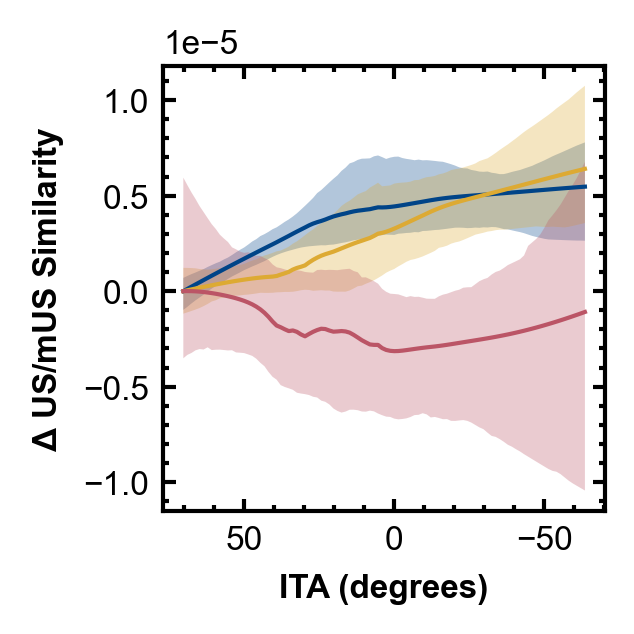

In [7]:
fig, ax = plt.subplots(figsize=(2, 2))

df_summary = pd.read_parquet("pw_us_sim_labelled.parquet")
df_summary = df_summary[df_summary["Label"] == "Bicep"]

for n, g in df_summary.groupby("Wavelengths"):
    if n not in [700, 800, 1080]:
        continue
    X, Y, Ymax, Ymin = loess_bootstrap(
        g["ITA"].values, g["SSIM"].values, frac=0.66666, it=2
    )
    # ax.scatter(g["ITA"], g["SSIM"], s=5, label=f"{n:.0f} nm")
    ax.plot(X, Y - Y[-1])
    ax.fill_between(X, Ymin - Y[-1], Ymax - Y[-1], alpha=0.3)
    print(spearmanr(g["ITA"], g["SSIM"]).pvalue)
ax.invert_xaxis()
ax.set_xlabel("ITA (degrees)")
ax.set_ylabel(r"$\mathdefault{\Delta}$ US/mUS Similarity")
# plt.savefig("figure7.pdf", dpi=300)
# plt.savefig("figure7.svg", dpi=300)
plt.show()

Radial artery 700.0 nm 0.9376346047878227
Radial artery 800.0 nm 0.6646670492236655
Radial artery 1080.0 nm 0.6175002917720764
Bicep 700.0 nm 7.690501221473002e-05
Bicep 800.0 nm 0.0006224198508826486
Bicep 1080.0 nm 0.416581829333906


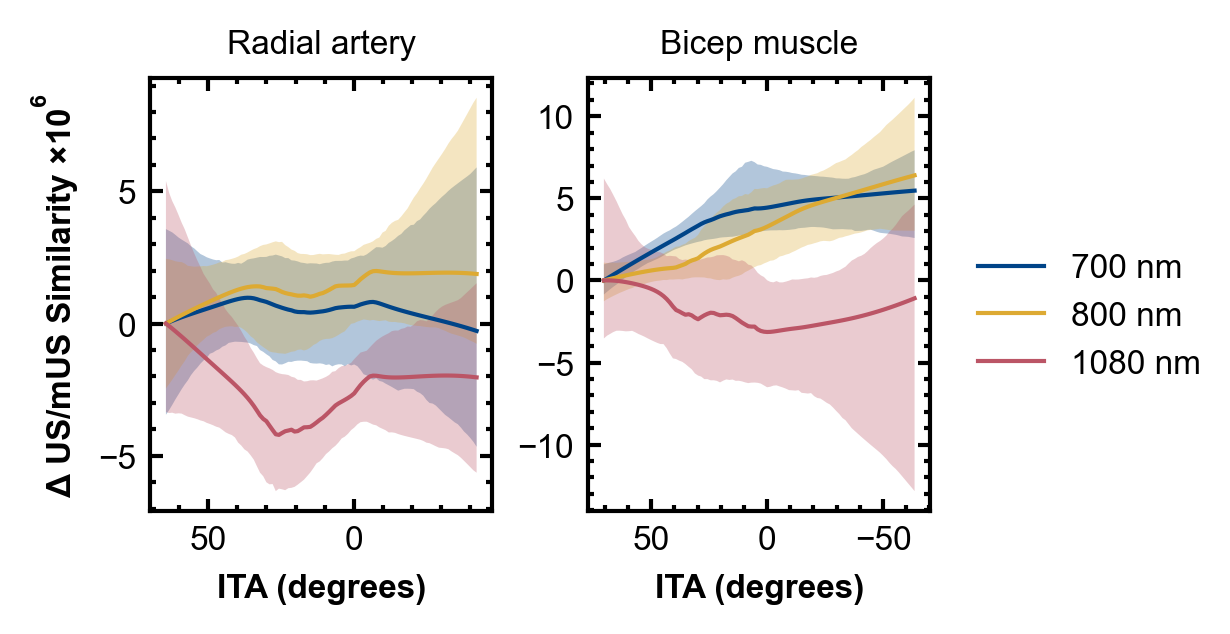

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2), constrained_layout=True)

# fig.get_layout_engine().set(w_pad=0.01)
df_summary = pd.read_parquet("pw_us_sim_labelled.parquet")
df_summary = df_summary[df_summary["Label"] == "Forearm"]

for n, g in df_summary.groupby("Wavelengths"):
    if n not in [700, 800, 1080]:
        continue
    X, Y, Ymax, Ymin = loess_bootstrap(
        g["ITA"].values, g["SSIM"].values * 1e6, frac=0.66666, it=2
    )
    # ax.scatter(g["ITA"], g["SSIM"], s=5, label=f"{n:.0f} nm")
    ax1.plot(X, Y - Y[-1], label=f"{n:.0f} nm")
    ax1.fill_between(X, Ymin - Y[-1], Ymax - Y[-1], alpha=0.3)
    print("Radial artery", n, "nm", spearmanr(g["ITA"], g["SSIM"]).pvalue)


df_summary = pd.read_parquet("pw_us_sim_labelled.parquet")
df_summary = df_summary[df_summary["Label"] == "Bicep"]

for n, g in df_summary.groupby("Wavelengths"):
    if n not in [700, 800, 1080]:
        continue
    X, Y, Ymax, Ymin = loess_bootstrap(
        g["ITA"].values, g["SSIM"].values * 1e6, frac=0.66666, it=2
    )
    # ax.scatter(g["ITA"], g["SSIM"], s=5, label=f"{n:.0f} nm")
    ax2.plot(X, Y - Y[-1])
    ax2.fill_between(X, Ymin - Y[-1], Ymax - Y[-1], alpha=0.3)
    print("Bicep", n, "nm", spearmanr(g["ITA"], g["SSIM"]).pvalue)

ax1.invert_xaxis()
ax2.invert_xaxis()
ax1.set_xlabel("ITA (degrees)")
ax2.set_xlabel("ITA (degrees)")
ax1.set_ylabel(r"$\mathdefault{\Delta}$ US/mUS Similarity $\mathdefault{\times 10^6}$")
ax1.set_title("Radial artery", fontsize="medium", fontweight="normal")
ax2.set_title("Bicep muscle", fontsize="medium", fontweight="normal")
fig.legend(loc="outside right")
fig.savefig("ssim.pdf", dpi=300)
plt.show()

0.03413438769143957
0.004352844621492018
0.5956803344267365


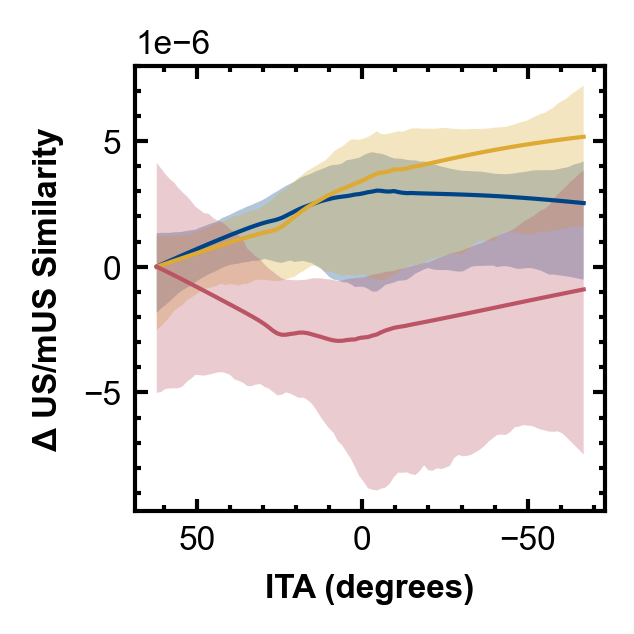

In [9]:
fig, ax = plt.subplots(figsize=(2, 2))

df_summary = pd.read_parquet("pw_us_sim_labelled.parquet")
df_summary = df_summary[df_summary["Label"] == "Leg"]

for n, g in df_summary.groupby("Wavelengths"):
    if n not in [700, 800, 1080]:
        continue
    X, Y, Ymax, Ymin = loess_bootstrap(
        g["ITA"].values, g["SSIM"].values, frac=0.66666, it=2
    )
    # ax.scatter(g["ITA"], g["SSIM"], s=5, label=f"{n:.0f} nm")
    ax.plot(X, Y - Y[-1])
    ax.fill_between(X, Ymin - Y[-1], Ymax - Y[-1], alpha=0.3)
    print(spearmanr(g["ITA"], g["SSIM"]).pvalue)
ax.invert_xaxis()
ax.set_xlabel("ITA (degrees)")
ax.set_ylabel(r"$\mathdefault{\Delta}$ US/mUS Similarity")
# plt.savefig("figure7.pdf", dpi=300)
# plt.savefig("figure7.svg", dpi=300)
plt.show()

0.025656704268387752
0.00023806831671377342
0.7304611210430043


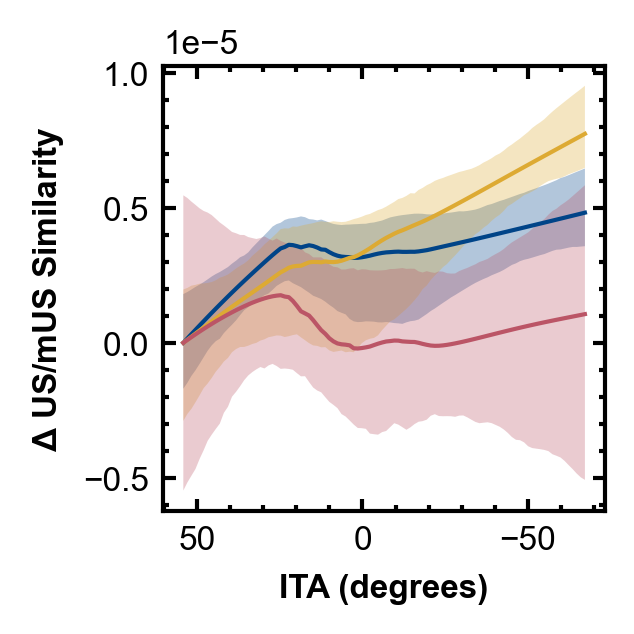

In [10]:
fig, ax = plt.subplots(figsize=(2, 2))

df_summary = pd.read_parquet("pw_us_sim_labelled.parquet")
df_summary = df_summary[df_summary["Label"] == "Neck"]

for n, g in df_summary.groupby("Wavelengths"):
    if n not in [700, 800, 1080]:
        continue
    X, Y, Ymax, Ymin = loess_bootstrap(
        g["ITA"].values, g["SSIM"].values, frac=0.66666, it=2
    )
    # ax.scatter(g["ITA"], g["SSIM"], s=5, label=f"{n:.0f} nm")
    ax.plot(X, Y - Y[-1])
    ax.fill_between(X, Ymin - Y[-1], Ymax - Y[-1], alpha=0.3)
    print(spearmanr(g["ITA"], g["SSIM"]).pvalue)
ax.invert_xaxis()
ax.set_xlabel("ITA (degrees)")
ax.set_ylabel(r"$\mathdefault{\Delta}$ US/mUS Similarity")
# plt.savefig("figure7.pdf", dpi=300)
# plt.savefig("figure7.svg", dpi=300)
plt.show()